1. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
2. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).
3. __Use the__ `Validate` __button in the Assignments tab before submitting__.

__Include comments, derivations, explanations, graphs, etc.__ 

You __work in groups__ (= 3 people). __Write the full name and S/U-number of all team members!__

---

# Assignment 4 (Statistical Machine Learning 2024)
# **Deadline: 21 December 2024**

## Instructions
* Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` __including comments, derivations, explanations, graphs, etc.__ 
Elements and/or intermediate steps required to derive the answer have to be in the report. If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends.
* __Please use LaTeX to write down equations/derivations/other math__! How to do that in Markdown cells can be found [here](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/), a starting point for various symbols is [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).
* Please do __not add new cells__ to the notebook, try to write the answers only in the provided cells. Before you turn the assignment in, make sure everything runs as expected.
* __Use the variable names given in the exercises__, do not assign your own variable names. 
* __Only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.

For any problems or questions regarding the assignments, ask during the tutorial or send an email to charlotte.cambiervannooten@ru.nl and janneke.verbeek@ru.nl .

## Introduction
Assignment 4 consists of:
1. Bayesian inference in binary response problem (50 points);
2. The EM algorithm for doping detection (50 points)__;
3. __Gibbs sampling and Metropolis-Hastings (50 points)__;
4. State-Space models (50 points).

## Libraries

Please __avoid installing new packages__, unless really necessary.

In [165]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Set fixed random seed for reproducibility
np.random.seed(2022)

## Gibbs sampling and Metropolis-Hastings (50 points)
Exact inference is often not tractable in real-world probabilistic models. By *exact*, we mean that the likelihood and posterior are available in closed form (as an analytical expression). For example, recall *Gaussian processes regression*: we have a Gaussian process prior and a Gaussian likelihood that conveniently result in a Gaussian process posterior. It is, however, not the case when we want to use Gaussian processes for classification. We have a Gaussian process prior, yet, the likelihood has to be, for example, sigmoid (logistic) or cumulative normal (probit). Such a prior and likelihood will not give us the Gaussian process posterior anymore. Thus, some other methods would have to be used for this purpose, such as *Laplace approximation*, *Expectation Propagation*, or *Markov Chain Monte Carlo methods*. In particular, for the Gaussian processes classification problem, one could use **Gibbs sampling**. In this exercise we will avoid some cumbersome derivations related to more complex problems (such as GP classification) and implement Gibbs sampling and Metropolis-Hastings for toy problems to illustrate the intuition behind the algorithms. 
### Gibbs sampler
Consider a two-dimensional Gaussian distribution $\boldsymbol{x}\sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ with parameters 
\begin{equation}
\boldsymbol{\mu}=
\begin{bmatrix}
1\\
2
\end{bmatrix}\quad
\boldsymbol{\Sigma}=\begin{bmatrix}
1&0.8\\
0.8&2
\end{bmatrix}
\end{equation}
1. Write down the relevant conditional densities for sampling from a 2D Gaussian, write down the iterations of the Gibbs sampler for sampling from a 2D Gaussian. 

**Begin Answer**

According to Bishop we have the following equations that describe the mean and covariance of a conditional distribution $p(x_a|x_b)$:

$$
\begin{align}
\mu_{a|b} &= \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(x_b - \mu_b)\\
\Sigma_{a|b} &= \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}
\end{align}
$$

Thus for $p(x_1|x_2)$ we have the following:

$$
\begin{align}
\mu_{1|2} &= \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(x_2 - \mu_2) = 1 + (0.8)(x_2 - 2)/2 = 0.4x_2+0.2\\
\Sigma_{1|2} &= \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21} = 1 - 0.8(0.8)/(2) = 0.68
\end{align}
$$

And for $p(x_2|x_1)$ we have the following:

$$
\begin{align}
\mu_{2|1} &= \mu_2 + \Sigma_{21}\Sigma_{11}^{-1}(x_1 - \mu_1) = 2 + 0.8(1)(x_1-1)=0.8x_1 + 1.2\\
\Sigma_{2|1} &= \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12} = 2 - 0.8(1)(0.8)  = 1.36
\end{align}
$$

Thus for the final conditional distributions that we use in Gibbs sampling we have:
$$
\begin{align}
p(x_1|x_2) &\sim \mathcal{N}(x_1 | \mu=0.4x_2+0.2, \Sigma=0.68)\\
p(x_2|x_1) &\sim \mathcal{N}(x_2 | \mu=0.8x_1+1.2, \Sigma=1.36)
\end{align}
$$

Now that we have the appropriate conditional distributions, we can write down the iterations required in a Gibbs sampler:

1. Initialize $x_1, x_2$
2. For $\tau = 1,\dots,T:$
    - Sample $x_1^{\tau+1} \sim P(x_1|x_2^{\tau})$
    - Sample $x_2^{\tau+1} \sim P(x_2|x_2^{\tau+1})$

**End Answer**

2. Implement the Gibbs sampler. Start with an initial guess $[-1.5, 4]^{T}$. Plot the Gaussian contours along with the initial guess after 2, 5, and 100 full cycles of the Gibbs sampler. 

First, create a function that plots the contours, the initial guess, and the generated samples. 

In [166]:

def gauss_contour(mu, sigma, init_guess, samples=[], title='Initial guess'):
    """
    Function to plot Gaussian contours and initial guess.

    Parameters
    ----------
    mu : (2,) np.ndarray
        The mean.
    sigma : (2,2) np.ndarray
        The covariance.
    init_guess : (2,) np.ndarray
        The array containing the initial guess.
    samples : (T,2) np.ndarray
        The array containing the generated samples.
    title : The title of the plot.

    Returns
    -------
    """
    x_upper = 4
    x = np.linspace(-2, x_upper, 100)
    y = np.linspace(-2, 6, 100)
    x, y = np.meshgrid(x, y)
    mvn = multivariate_normal(mu, sigma)
    data = np.dstack((x, y))
    z = mvn.pdf(data)
    plt.contourf(x, y, z)
    
    # Plot generated samples as scattered pionts
    size = 5
    if len(samples) < 1000:
        size = 20
    plt.scatter(samples[:,0], samples[:,1], s=size, color="cyan")

    # Progression
    if len(samples) < 100:
        for i in range(1, len(samples)):
            xs = [samples[i-1][0], samples[i][0], samples[i][0]]
            ys = [samples[i-1][1], samples[i-1][1], samples[i][1]]
            plt.plot(xs, ys)


    # Plot initial point
    plt.scatter(init_guess[0], init_guess[1], s=20, color="lime", label="Initial")

    plt.grid()
    plt.legend()
    plt.xlim((-2, x_upper))
    plt.ylim((-2,6))
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title(f"Gibbs Sampling With {len(samples)} Samples")
    plt.show()




Implement the Gibbs sampler.

In [167]:
def Gibbs(mu, sigma, init_guess, T):
    """
    Generates gibbs samples

    Parameters
    ----------
    mu : (2,) np.ndarray
        The mean.
    sigma : (2,2) np.ndarray
        The covariance.
    init_guess : (2,) np.ndarray
        The array containing the initial guess.
    T : integer
        The number of samples to generate.

    Returns
    -------
    The samples generated.
    """
    samples = np.zeros((T, 2))
    samples[0] = init_guess.reshape(1,-1)


    # Define conditional covariance
    sigma_a_given_b = lambda a, b : sigma[a][a]-sigma[a][b]*sigma[b][a]/sigma[b][b]
    
    sigma_1_given_2 = sigma_a_given_b(0,1)
    sigma_2_given_1 = sigma_a_given_b(1,0)

    # Define conditional means
    mu_a_given_b = lambda a, b, x : mu[a] + sigma[a][b]*(1/sigma[b][b])*(x - mu[b])

    # Make samples
    for i in range(1, T):
        x1 = multivariate_normal(mu_a_given_b(0,1,samples[i-1][1]), sigma_1_given_2).rvs(1)
        x2 = multivariate_normal(mu_a_given_b(1,0,x1), sigma_2_given_1).rvs(1)
        samples[i] = [x1, x2]

    return samples





Run the Gibbs sampler and plot the results.

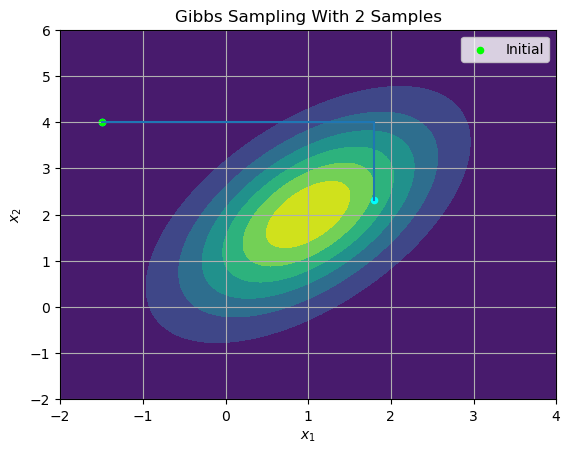

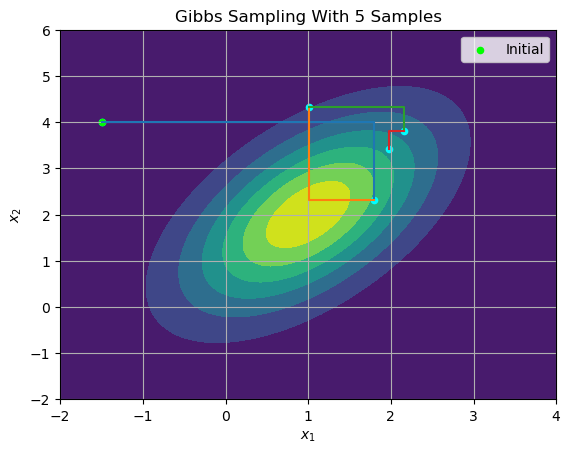

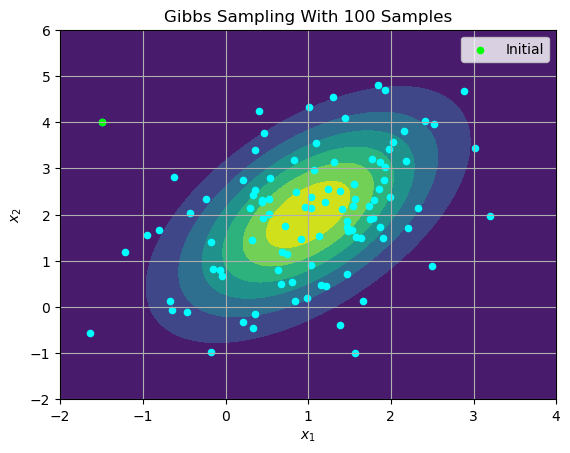

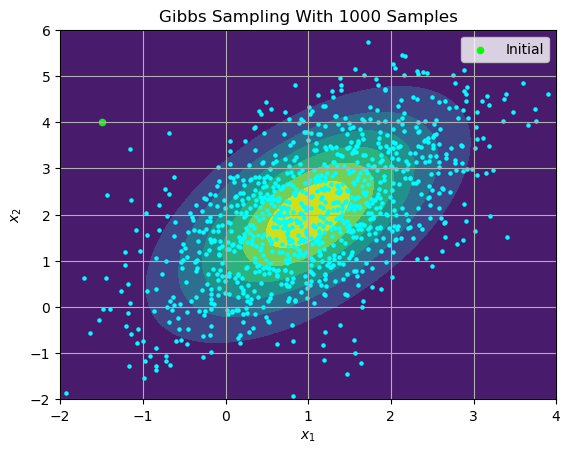

In [168]:
"""
Define the initial guess, the mean, the covariance, and run the Gibbs sampler.
"""
mean = np.array([1, 2])
covariance = np.array([[1, 0.8], [0.8, 2]])
init = np.array([-1.5, 4])
sample_sizes = [2, 5, 100, 1000]

samples = Gibbs(mean, covariance, init, 1000)

for sample_size in sample_sizes:
    gauss_contour(mean, covariance, init, samples[:sample_size])

3. Compute the sample mean and sample covariance after 50, 100, 500, and 1000 samples.

In [169]:
"""
Compute the sample mean and covariance.
"""

samples = Gibbs(mean, covariance, init, 10000)
sample_sizes = [50, 100, 500, 1000, 10000]

for sample_size in sample_sizes:
    mean = np.mean(samples[:sample_size], axis=0)
    cov = np.cov(samples[:sample_size].reshape(2,-1))

    print(f"At {sample_size} samples:")
    print(f"Mean:\n {mean} \n")
    print(f"Covariance:\n {cov} \n")

At 50 samples:
Mean:
 [0.86677265 1.88913864] 

Covariance:
 [[2.57053503 0.15917208]
 [0.15917208 1.1027698 ]] 

At 100 samples:
Mean:
 [0.99185554 2.08000104] 

Covariance:
 [[1.95143251 0.72996772]
 [0.72996772 1.2858509 ]] 

At 500 samples:
Mean:
 [0.99294688 2.05448929] 

Covariance:
 [[1.59094774 0.35204143]
 [0.35204143 1.85401267]] 

At 1000 samples:
Mean:
 [1.03335029 2.06029758] 

Covariance:
 [[1.7218188  0.2082441 ]
 [0.2082441  1.67404911]] 

At 10000 samples:
Mean:
 [1.01043119 2.00827945] 

Covariance:
 [[1.75421801 0.23557494]
 [0.23557494 1.76011436]] 



Comment on the results.

Hmm it seems that the mean values get closer and closer to the true values, but the covariance matrix doesn't seem to get that much closer to the true values, even at 10,000 samples. Perhaps something is wrong?

### Metropolis-Hastings
Here, we will continue working with bivariate Gaussian distribution. However, we will set up the problem differently. Assume now that the correlation parameter $\rho$ is unknown (while the mean and variances remain known):
\begin{equation}
\boldsymbol{\mu}=
\begin{bmatrix}
0\\
0
\end{bmatrix}\,\,\,\,\,\,\,\,\,\,
\boldsymbol{\Sigma}=\begin{bmatrix}
1&\rho\\
\rho&1
\end{bmatrix}
\end{equation}
The likelihood function follows
\begin{equation}
p(x_{1}^{1:N}, x_{2}^{1:N}|\rho)=\prod_{i=1}^{N}\frac{1}{2\pi\sqrt{1-\rho^{2}}}\exp\left(-\frac{1}{2(1-\rho^{2})}[(x_{1}^{i})^{2}-2\rho x_{1}^{i}x_{2}^{i}+(x_{2}^{i})^{2}] \right),
\tag{1}
\end{equation}
where index $i$ represents the $i^{th}$ observation. Further, we want to specify an uninformative prior on our covariance matrix. It is common to take the Jeffreys prior (https://en.wikipedia.org/wiki/Jeffreys_prior). In our case, it will become
\begin{equation}
p(\rho)=\frac{1}{|\Sigma^{3/2}|}=\frac{1}{\begin{vmatrix} 1&\rho\\
	\rho&1\end{vmatrix}^{3/2}}=1/(1-\rho^{2})^{3/2}.
\tag{2}
\end{equation}
If you use Bayes's rule for finding the posterior of $p(\rho)$ you will realize that it is not of any known form. So further we will infer $p(\rho|x_{1}^{1:N}, x_{2}^{1:N})$ using the Metropolis-Hastings algorithm.
For this exercise, generate $N=1000$ data points from multivariate normal with the parameters:
\begin{equation}
\boldsymbol{\mu}=
\begin{bmatrix}
0\\
0
\end{bmatrix}\,\,\,\,\,\,\,\,\,\,
\boldsymbol{\Sigma}=\begin{bmatrix}
1&0.4\\
0.4&1
\end{bmatrix},
\end{equation}
so we know the ground thruth $\rho=0.4$. 
1. In this exercise we will implement the Metropolis-Hastings algorithm. Let us first specify the proposal distribution:
\begin{equation}
\rho^{cand}\sim Uniform(\rho^{k-1}-0.07, \rho^{k-1}+ 0.07), 
\end{equation}
where $k$ is the interation of the Metropolis-Hastings algorithm. Comment on this proposal distribution (is it symmetric? does that help?). Write down the formula for the Metropolis-Hastings acceptance function using this proposal distribution. Comment on the role of acceptance function in this algorithm.

**Begin Answer**

The proposal distribution is symmetric given that it is uniform and has the same probability everywhere hence $q(x|y) = q(y|x)$. This helps simplify the basic acceptance function from 

$$
\begin{align}
A_k(z^*,z^{(\tau)})=\text{min} \left(1, \frac{p(z^*)q_k(z^{(\tau)}|z^*)}{p(z^{(\tau)})q_k(z^*|z^{(\tau)})} \right)
\end{align}
$$

To

$$
\begin{align}
A_k(z^*,z^{(\tau)})=\text{min} \left(1, \frac{p(z^*)}{p(z^{(\tau)})} \right)
\end{align}
$$

Where $q$ is the proposal distribution and $p$ is the likelihood. The proposal distribution suggests a new candidate $Z^*$ and this new candidate sample is accepted with probability equal to the acceptance ratio. If the proposal is more likely than the current position, we make the move, otherwise we make a move with probability equal to the acceptance ratio.

**End Answer**

2. Implement the Metropolis-Hastings algorithm for this problem and the proposal function defined above.

    **Note:** We added the functions `log_joint_probability` and `acceptance_function` to help you with the implementation, but their use is optional.

In [170]:
def log_joint_probability(X, rho):
    """
    Calculates log of joint probability.

    Parameters
    ----------
    X : (N, 2) np.ndarray
        Data points.
    rho : float
        Correlation parameter.

    Returns
    -------
    log-probability of X and rho
    """
    # YOUR CODE HERE
    
    first_term_likelihood = -((len(X)-3)/2)*np.log(1-rho**2)
    second_term_likelihood = -np.sum((X[:,0]**2-2*rho*X[:,0]*X[:,1]+X[:,1]**2), axis=0)/(2*(1-rho**2))
    return first_term_likelihood + second_term_likelihood

In [171]:

def acceptance_function(X, rho_candidate, rho_current):
    """
    Computes acceptance probability of a candidate.

    Parameters
    ----------
    X : (N, 2) np.ndarray
        Data points.
    rho_candidate : float
        Candidate sample.
    rho_current : float
        Current sample.

    Returns
    -------
    Value of acceptance function for given rho_candidate and rho_current.
    """
    numerator = log_joint_probability(X, rho_candidate)
    denominator = log_joint_probability(X, rho_current)

    return min(1, np.exp(numerator-denominator))

In [172]:
def metropolis_hastings(X, half_interval_len, T):
    """
    Metropolis-Hastings sampling implementation and plotting of the results.

    Parameters
    ----------
    X : (N, 2) np.ndarray
        Data points.
    half_interval_len : float
        Half interval length for the proposal uniform distribution centered around the current state.
    T : integer
        Number of iterations.

    Returns
    -------
    Accepted samples.
    """
    accepted = 0
    rho = 0
    rhos = np.zeros((T,1))
    rhos[0] = rho

    for i in range(0, T-1):
        # Draw sample from proposal distribution
        rho_candidate = np.random.uniform(rhos[i]-half_interval_len, rhos[i]+half_interval_len, 1)[0]
        acceptance_rate = acceptance_function(X, rho_candidate, rhos[i])

        if acceptance_rate > np.random.uniform(0,1,1):
            rhos[i+1] = rho_candidate
            accepted += 1
        else:
            rhos[i+1] = rhos[i]

    acceptance_rate = accepted/T

    return (rhos, acceptance_rate)



Run Metropolis-Hastings for 10000 iterations. You can use the initial value of $\rho^{0}=0$. After sampling $\rho$ 10000 times report the acceptance rate, the mean, and the standard deviation of the samples. Plot the trace plot for $\rho$ (i.e., value $\rho^{k}$ at each iteration of the algorithm). Plot the histogram of the posterior distribution of $\rho$ based on the samples in the chain.

In [173]:
def print_results(half_interval, num_samples):

    # Generate data points
    X = multivariate_normal([0, 0], np.array([[1, 0.4], [0.4, 1]])).rvs(1000)

    # Generate samples 
    rhos, acceptance_rate = metropolis_hastings(X, half_interval_len=half_interval, T=num_samples)

    # Times
    figure, axis = plt.subplots(1, 2, figsize=(15, 5))
    
    # Trace plot
    ts = np.arange(0, num_samples)
    axis[0].plot(ts, rhos)
    axis[0].axhline(0.4, color="green", label=r"True $\rho$")
    axis[0].set_ylabel(r"$\rho$")
    axis[0].set_xlabel("Iteration")
    axis[0].set_title(fr"Trace Plot of $\rho$, half interval={half_interval}")
    axis[0].legend()

    # Histogram
    axis[1].hist(rhos, 100)
    axis[1].axvline(0.4, color="green", label=r"True $\rho$")
    axis[1].set_ylabel("Frequency")
    axis[1].set_xlabel(r"$\rho$")
    axis[1].set_title(r"$P(\rho\|X)$")
    axis[1].legend()
    
    plt.show()

    # Metrics
    mean = np.mean(rhos)
    std = np.std(rhos)
    print(f"Mean: {mean}")
    print(f"Std: {std}")
    print(f"Acceptance rate: {acceptance_rate*100}%")

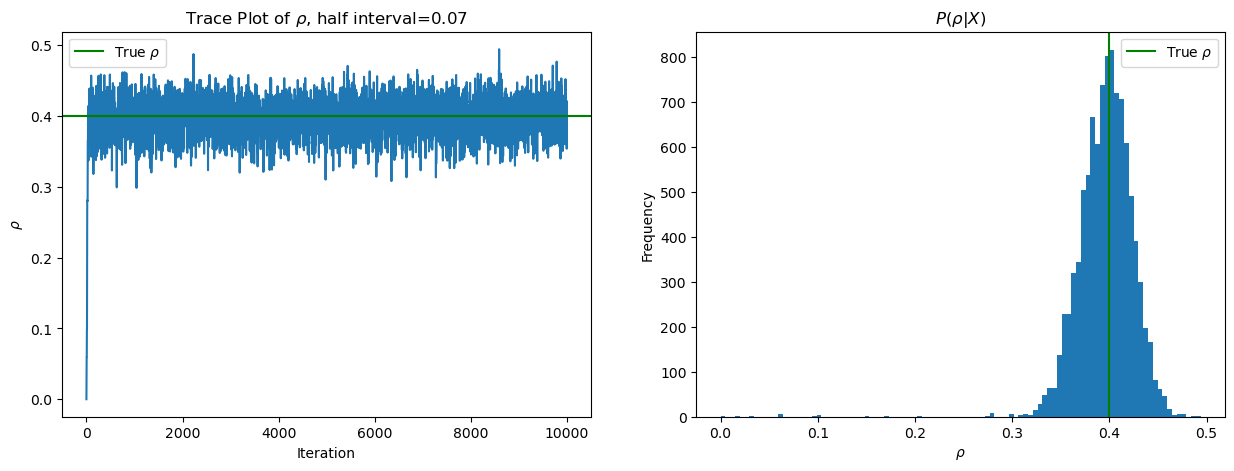

Mean: 0.3962856363853632
Std: 0.028425186461385685
Acceptance rate: 52.129999999999995%


In [174]:
print_results(0.07, 10_000)

3. Try changing the proposal distribution to 
\begin{equation}
\rho^{cand}\sim Uniform(\rho^{k-1}-0.01, \rho^{k-1}+ 0.01), 
\end{equation}
and 
\begin{equation}
\rho^{cand}\sim Uniform(\rho^{k-1}-0.3, \rho^{k-1}+ 0.3).
\end{equation}
Run Metropolis-Hastings with the new proposal distributions. Once again, report the acceptance rate, the mean and the standard deviation. Plot the trace plot and the histogram.

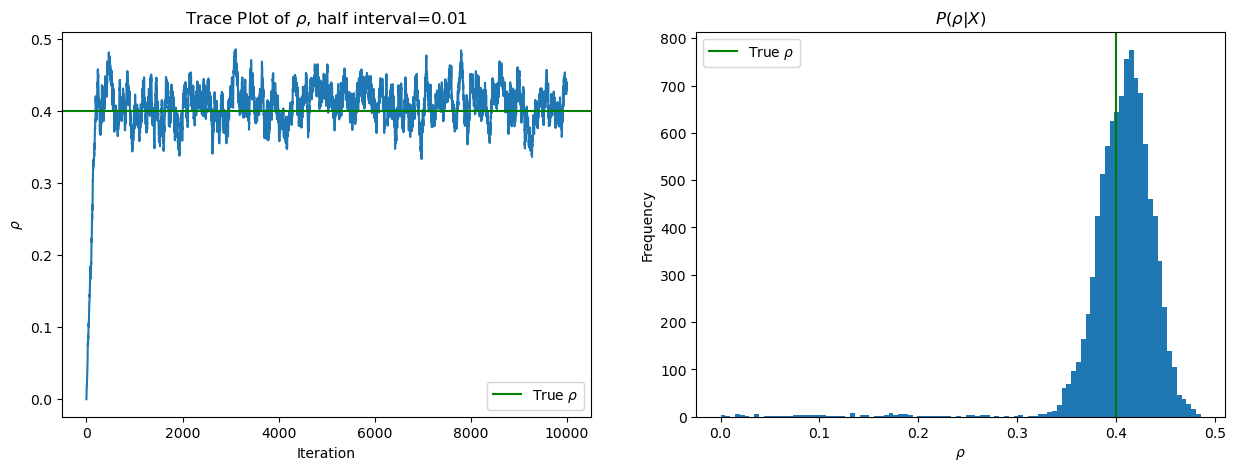

Mean: 0.40616071399513487
Std: 0.04078756258396515
Acceptance rate: 92.33%


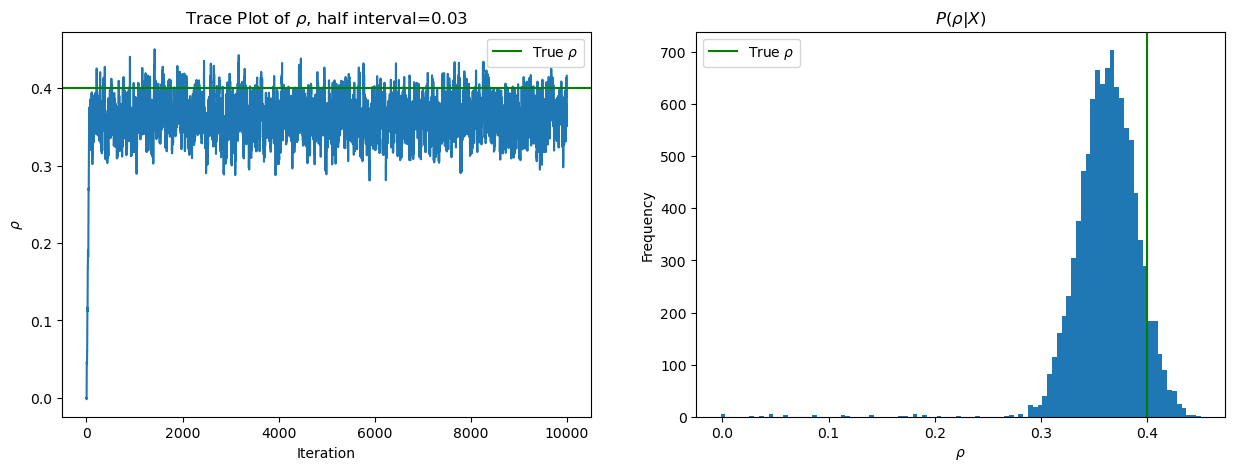

Mean: 0.3623302192772902
Std: 0.031078897515854693
Acceptance rate: 76.03%


In [175]:
"""
Run Metropolis-Hastings with the new proposal distributions.
Once again, report the acceptance rate, the mean and the standard deviation. Plot the trace plot and the histogram.
"""
print_results(0.01, 10_000)
print_results(0.03, 10_000)


Comment on how changing the proposal distribution changes your results.

A proposal distribution with larger jumps, say with the half_interval set to 0.01, proposes less drastic changes and thus is accepted far more often - 92%. However as we increase the variance of the proposal distribution to 0.03 and 0.07, the proposal distribution starts suggesting less likely candidate values that are rejected more often leading to a lower acceptance rate of 76% and 50% respectively. It seems that using 0.01 resulted in the best approximation of $\rho$ with an average of 0.406, closely followed by 0.07 with a mean of 0.396 and finally 0.03 with a mean of 0.36.